#Импортируем нужные библиотеки, нейросеть будем писать на PyTorch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 95.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

from sklearn.preprocessing import LabelEncoder


#Загрузим дасет [Emotions dataset for NLP](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp?select=train.txt)

In [ ]:
train_df = pd.read_csv('train.txt', names=['text', 'emotion'], sep=';')
val_df = pd.read_csv('val.txt', names=['text', 'emotion'], sep=';')
test_df = pd.read_csv('test.txt', names=['text', 'emotion'], sep=';')

train_df.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


Посмотрим распределение на классы эмоций:

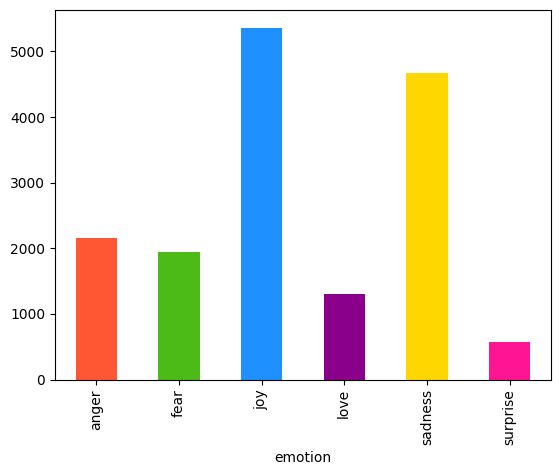

In [ ]:
train_df.groupby(['emotion']).size().plot.bar(color=['#FF5733', '#4CBB17', '#1E90FF', '#8B008B', '#FFD700', '#FF1493']);

#Загрузка предобученной модели BERT

In [ ]:
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

#Создадим Dataset класс для нашего набора данных

In [ ]:
# выбреем максимальную длинну слова 256, так как более 75% текста будут иметь такую длину

train_df['text'].apply(lambda x : len(x)).describe()

count    16000.000000
mean        96.845812
std         55.904953
min          7.000000
25%         53.000000
50%         86.000000
75%        129.000000
max        300.000000
Name: text, dtype: float64

In [ ]:
# Гиперпараметры модели

MAX_LEN = 256
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 4
LEARNING_RATE = 1e-05

Закодируем целевую переменную (категории эмоций)

In [ ]:
le = LabelEncoder()
train_df['emotion'] = le.fit_transform(train_df['emotion'])
val_df['emotion'] = le.transform(val_df['emotion'])
val_df.head()

,text,emotion
0,im feeling quite sad and sorry for myself but ...,4
1,i feel like i am still looking at a blank canv...,4
2,i feel like a faithful servant,3
3,i am just feeling cranky and blue,0
4,i can have for a treat or if i am feeling festive,2


In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = str(self.df.loc[index, 'text'])
        emotion = self.df.loc[index, 'emotion']
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'emotion': torch.tensor(emotion, dtype=torch.long)
        }

Создадим DataLoader

In [ ]:
train_dataset = EmotionDataset(train_df, tokenizer, MAX_LEN )
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE ,
                          shuffle=True)

val_dataset = EmotionDataset(val_df, tokenizer, MAX_LEN)
val_loader = DataLoader(val_dataset, batch_size=VALID_BATCH_SIZE )

#Инициализация нейронной сети BertClassifier на основе BERT

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, bert_model_name, dropout=0.2):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout1 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(768, 256)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(256, 6)

    def forward(self, input_ids, attention_mask):

        outputs = self.bert(input_ids=input_ids, 
                            attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout1(pooled_output)
        output = self.fc1(pooled_output)
        output = self.relu(output)
        output = self.dropout2(output)
        logits = self.fc2(output)
        
        return logits

#Обучение сети

In [ ]:
def train(model, train_data_loader, val_data_loader, optimizer, criterion, 
          device, EPOCHS):

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(EPOCHS):
      print(f'Epoch {epoch + 1} ')
    
      # переводим модель в режим обучения
      model.train()

      # инициализируем Loss и метрику Accuracy
      total_loss_train, total_accuracy_train = 0, 0
      
      # итерируемся по бачам
      for data in tqdm(train_data_loader):
          # переносим данные на device
          input_ids = data['input_ids'].to(device)
          attention_mask = data['attention_mask'].to(device)
          labels = data['emotion'].to(device)
          
          # обнуляем градиенты
          optimizer.zero_grad()
      
          # получаем предсказанные значения
          outputs = model(input_ids, attention_mask)

          # получаем loss
          loss = criterion(outputs, labels)
          total_loss_train += loss.item()
          
          # считаем accuracy
          logits = outputs.detach().cpu().numpy()
          label_ids = labels.to('cpu').numpy()

          total_accuracy_train += flat_accuracy(logits, label_ids)

          # производим backpropagation и делаем шаг оптимизации
          loss.backward()
          optimizer.step()

      # считаем средний loss и accuracy
      avg_loss_train = total_loss_train / len(train_data_loader)
      avg_acc_train = total_accuracy_train / len(train_data_loader)

      train_losses.append(avg_loss_train)
      train_accuracies.append(avg_acc_train)     


      # переводим модель в режим пердсказания
      model.eval()
      
      # инициализируем Loss и метрику Accuracy
      total_loss_val = 0
      total_accuracy_val = 0
      
      # итерируемся по бачам
      for data in tqdm(val_data_loader):
          # переносим данные на device
          input_ids = data['input_ids'].to(device)
          attention_mask = data['attention_mask'].to(device)
          labels = data['emotion'].to(device)
          
          # отключить вычисление градиента
          with torch.no_grad():
              # получаем предсказание модели
              outputs = model(input_ids, attention_mask)
              
              # получаем loss
              loss = criterion(outputs, labels)
              total_loss_val += loss.item()
              
              # считаем кол-во правильных предсказаний
              logits = outputs.detach().cpu().numpy()
              label_ids = labels.to('cpu').numpy()

              total_accuracy_val += flat_accuracy(logits, label_ids)
      
      # считаем средний loss и accuracy
      avg_loss = total_loss_val / len(val_data_loader)
      accuracy = total_accuracy_val / len(val_data_loader)

      val_losses.append(avg_loss)
      val_accuracies.append(accuracy)

      print(f'Train Loss: {avg_loss_train:.4f} | Train Acc: {avg_acc_train:.4f} | Val Loss: {avg_loss:.4f} | Val Acc: {accuracy:.4f}')

      # Сохраняем веса модели
      torch.save(model.state_dict(), f'weights_epoch{epoch + 1}.pt')

    return train_losses, train_accuracies, val_losses, val_accuracies



In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
model = BertClassifier('bert-base-uncased')

# используем Кросс энтропию для задачи многоклассовой классификации
criterion = nn.CrossEntropyLoss() 

# определяем устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# определяем оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# перемещаем model на device
model.to(device)

train_losses, train_accuracies, val_losses, val_accuracies = train(model, train_loader, val_loader, optimizer, criterion, device, EPOCHS)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch 1 


100%|██████████| 125/125 [00:31<00:00,  4.03it/s]


Train Loss: 0.8305 | Train Acc: 0.7194 | Val Loss: 0.3154 | Val Acc: 0.9105
Epoch 2 


100%|██████████| 125/125 [00:31<00:00,  4.01it/s]


Train Loss: 0.2228 | Train Acc: 0.9277 | Val Loss: 0.1828 | Val Acc: 0.9325
Epoch 3 


100%|██████████| 125/125 [00:31<00:00,  4.02it/s]


Train Loss: 0.1477 | Train Acc: 0.9435 | Val Loss: 0.1637 | Val Acc: 0.9325
Epoch 4 


100%|██████████| 125/125 [00:31<00:00,  4.02it/s]


Train Loss: 0.1143 | Train Acc: 0.9522 | Val Loss: 0.1333 | Val Acc: 0.9375


In [ ]:
#Функция для отрисовки прогресса обучения

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    # Строем граффик loss на обучающем и тестовом датасете
    ax[0].plot(train_losses, label='Обучающий Loss')
    ax[0].plot(val_losses, label='Тестовый Loss')
    
    ax[0].set_xlabel('Эпоха')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Обучающий и Тестовый Loss')
    ax[0].legend()
    
    # Строем граффик accuracy на обучающем и тестовом датасете
    ax[1].plot(train_accuracies, label='Обучающий Accuracy')
    ax[1].plot(val_accuracies, label='Тестовый Accuracy')
    ax[1].set_xlabel('Эпоха')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Обучающий и Тестовый Accuracy')
    
    plt.show()

#Тестим

In [ ]:
# создаем функцию predict

def predict(model, test_data):

    test = EmotionDataset(test_data, tokenizer, MAX_LEN)
    test_dataloader = DataLoader(test, batch_size=VALID_BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    # переводим модель в режим пердсказания
    model.eval()
    
    # инициализируем метрику Accuracy
    total_accuracy_test = 0
    
    # итерируемся по бачам
    for data in tqdm(test_dataloader):
        # переносим данные на device
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data['emotion'].to(device)
        
        # отключить вычисление градиента
        with torch.no_grad():
            # получаем предсказание модели
            outputs = model(input_ids, attention_mask)
        
            # считаем кол-во правильных предсказаний
            logits = outputs.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()

            total_accuracy_test += flat_accuracy(logits, label_ids)
    
    # считаем средний loss и accuracy
    accuracy = total_accuracy_test / len(test_dataloader)

    print(f'Accuracy на тесте: {accuracy: .3f}')


In [ ]:
test_df['emotion'] = le.transform(test_df['emotion']) # закодируем целевые переменные
    
predict(model, test_df)

100%|██████████| 125/125 [00:31<00:00,  4.02it/s]

Accuracy на тесте:  0.932


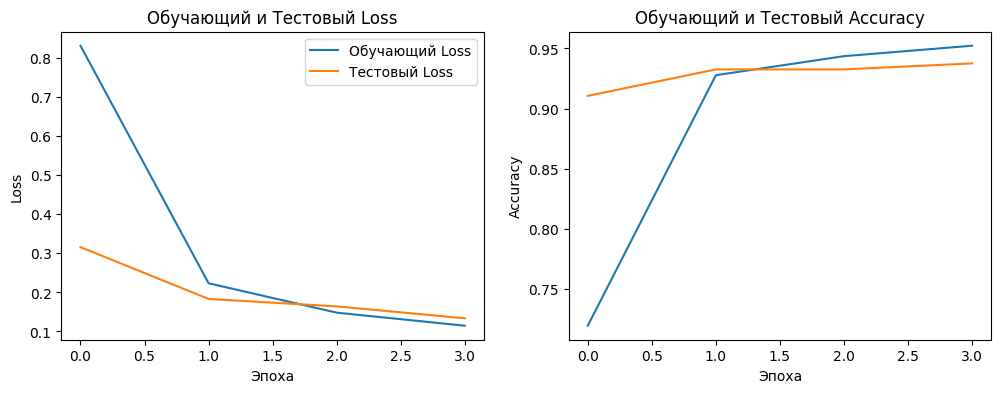

In [ ]:
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)